# Исследование данных Garpix на предмет возможности использования классических ML алгоритмов, для решения поставленной задачи. 

In [1]:
import numpy as np
import pandas as pd
from classes import GarpixZipReader
from sklearnex import patch_sklearn
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# Загрузка данных, полученных от системы GLS
data_reader = GarpixZipReader('../../data/data_2.zip')
raw_data = data_reader.read_zip()

### Первичная очистка данных
#### Просто избавляемся от ненужных, в данный момент полей в JSON и формируем необходимый нам список словарей с данными

In [3]:
full_boxes_list = []  # Полный список всех коробок, без учета грузового пространства
calculation_data = []  # Данные расчетов (Учитываются только коробки, поместившиеся в грузовое отделение, и рассчитанные данные по плотности укладки) 
for raw_item in raw_data:
    calculation = {}
    for box_item in raw_item['groups'][0]['cargoes']:
        # Собираем данные по всем коробкам
        box = {'width': float(box_item['width']),
               'height': float(box_item['height']),
               'length': float(box_item['length']),
               'mass': box_item['mass'],
               'stacking': box_item['stacking'],
               'turnover': box_item['turnover'],
               'is_rotate_y': box_item['is_rotate_y'],
               'stacking_limit': box_item['stacking_limit']
               }
        full_boxes_list.append(box)
    # Собираем данные по поместившимся коробкам, и расчетам плотности
    boxes = pd.json_normalize(raw_item['first_visual']['boxes'])[[
        'size.width', 'size.height', 'size.length', 'mass', 'stacking', 'turnover', 'is_rotate_y', 'stacking_limit'
    ]].rename(index=str, columns={'size.width': 'width', 'size.height': 'height', 'size.length': 'length'})
    calculation['boxes'] = boxes
    calculation['target'] = raw_item['first_visual']['calculation_info']['density_percent']
    calculation_data.append(calculation)
boxes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43 entries, 0 to 42
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   width           43 non-null     float64
 1   height          43 non-null     float64
 2   length          43 non-null     float64
 3   mass            43 non-null     float64
 4   stacking        43 non-null     bool   
 5   turnover        43 non-null     bool   
 6   is_rotate_y     43 non-null     bool   
 7   stacking_limit  43 non-null     float64
dtypes: bool(3), float64(5)
memory usage: 2.1+ KB


In [4]:
full_boxes_list = pd.DataFrame.from_dict(full_boxes_list)
full_boxes_list.drop_duplicates(inplace=True)
full_boxes_list.reset_index(inplace=True)
full_boxes_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           177 non-null    int64  
 1   width           177 non-null    float64
 2   height          177 non-null    float64
 3   length          177 non-null    float64
 4   mass            177 non-null    float64
 5   stacking        177 non-null    bool   
 6   turnover        177 non-null    bool   
 7   is_rotate_y     177 non-null    bool   
 8   stacking_limit  177 non-null    float64
dtypes: bool(3), float64(5), int64(1)
memory usage: 8.9 KB


In [5]:
for column in full_boxes_list.columns:
    display(full_boxes_list[column].describe())

count      177.000000
mean       810.836158
std       1940.548985
min          0.000000
25%        114.000000
50%        359.000000
75%        854.000000
max      23089.000000
Name: index, dtype: float64

count     177.000000
mean      896.214689
std       387.857796
min        56.000000
25%       670.000000
50%       800.000000
75%      1150.000000
max      3000.000000
Name: width, dtype: float64

count     177.000000
mean     1138.084746
std       526.900088
min        60.000000
25%       750.000000
50%      1150.000000
75%      1550.000000
max      2200.000000
Name: height, dtype: float64

count     177.000000
mean     1182.259887
std       466.611711
min       200.000000
25%       950.000000
50%      1200.000000
75%      1348.000000
max      2980.000000
Name: length, dtype: float64

count    177.000000
mean     159.581921
std      188.017937
min        2.000000
25%       50.000000
50%      100.000000
75%      200.000000
max      986.000000
Name: mass, dtype: float64

count       177
unique        2
top       False
freq        149
Name: stacking, dtype: object

count       177
unique        2
top       False
freq        156
Name: turnover, dtype: object

count      177
unique       2
top       True
freq       156
Name: is_rotate_y, dtype: object

count     177.000000
mean       28.531073
std       375.820452
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      5000.000000
Name: stacking_limit, dtype: float64

##### И так, всего мы имеем 177 видов коробок, по восемь параметров на каждую. 
##### Посмотрим на распределение этих коробок, для этого отобразим их в двумерное пространство с помощью алгоритма T-SNE

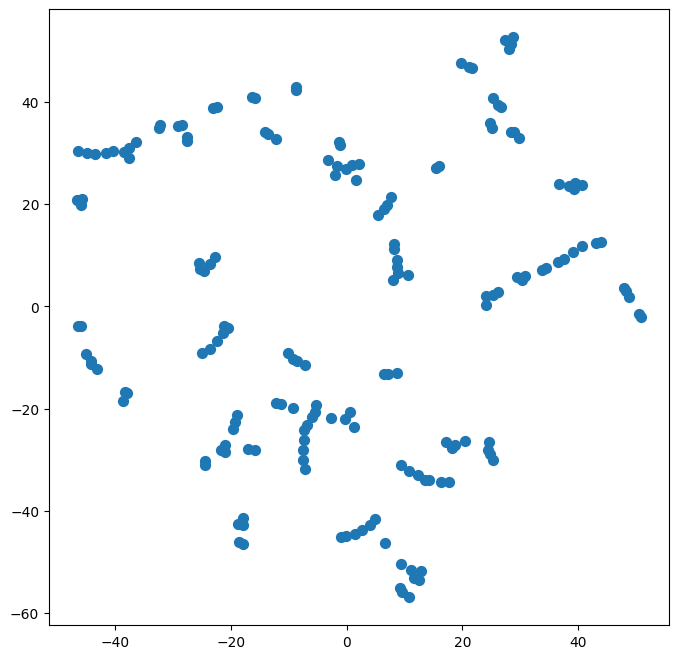

In [6]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3)
X_tsne = tsne.fit_transform(full_boxes_list.values)
plt.figure(figsize=(8, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=50)
plt.show()

#### Во входных данных, количество коробок во входном датасете всегда варьируется, но нам необходимо получить датасет в виде матрицы, пригодны для использования классическими ML алгоритмами.

##### Как можно заметить, мы можем кластеризовать коробки, для уменьшения количества классов в датафрейме который будем использовать для обучения алгоритмов. Но, пока попробуем обойтись без этого.

##### Для того что, бы привести исходный массив данных к табличному виду, сделаем каждый тип коробки одним классом (столбцом), по индексу, а значением будет количество коробок этого класса, уместившееся в грузовое пространство. 

In [7]:
# Формирование датасета для алгоритмов ML

def get_box_index(box_s, boxes_df):
    for ix, bx in boxes_df.iterrows():
        box = bx.to_numpy()
        box = np.delete(box, 0)
        if np.array_equal(box, box_s.to_numpy()):
            return ix
    return None


column_names = []
for i in range(1, 178):
    column_names.append(f'C_{i}')
column_names.append('target')

ml_dataset = pd.DataFrame(columns=column_names)
for item in calculation_data:
    values = list(map(lambda x: 0, range((len(column_names)))))  # Формируем пустой список со значениями
    values[-1] = item['target']
    for _, row in item['boxes'].iterrows():
        idx = get_box_index(row, full_boxes_list)
        if idx is not None:
            values[idx] += 1
    val_df = pd.DataFrame([dict(zip(column_names, values))])
    ml_dataset = pd.concat([ml_dataset, val_df], ignore_index=True)
ml_dataset.reset_index(inplace=True)
ml_dataset.info()

/tmp/ipykernel_20020/2814051794.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ml_dataset = pd.concat([ml_dataset, val_df], ignore_index=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Columns: 179 entries, index to target
dtypes: float64(1), int64(1), object(177)
memory usage: 6.8+ MB


In [8]:
ml_dataset.head()

,index,C_1,C_2,C_3,C_4,C_5,C_6,C_7,C_8,C_9,...,C_169,C_170,C_171,C_172,C_173,C_174,C_175,C_176,C_177,target
0,0,35,3,1,0,2,0,1,3,0,...,0,0,0,0,0,0,0,0,0,71.06767
1,1,11,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,79.61887
2,2,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,83.86312
3,3,8,0,0,0,6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,82.01980
4,4,2,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,77.21441


In [9]:
# Сохраним полученный датасет в файл
ml_dataset.to_csv('../../data/ml_dataset.csv')

### Теперь пришло время попробовать обучить ML алгоритмы на полученном датасете

In [10]:
best_models = {}

ml_dataset = ml_dataset.head(500)
X = ml_dataset.drop(columns=['target']).to_numpy()
Y = ml_dataset['target'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.22, random_state=0)
X_test.shape

(110, 178)

In [11]:
params = {
    'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0,
              8.0, 9.0, 10.0, 20, 50, 100, 500, 1000]}

model = Ridge()
grid_search = GridSearchCV(estimator=model,
                           param_grid=params,
                           scoring='neg_mean_absolute_error',
                           cv=5,
                           return_train_score=True,
                           verbose=1)
# Обучение модели на обучающих данных
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

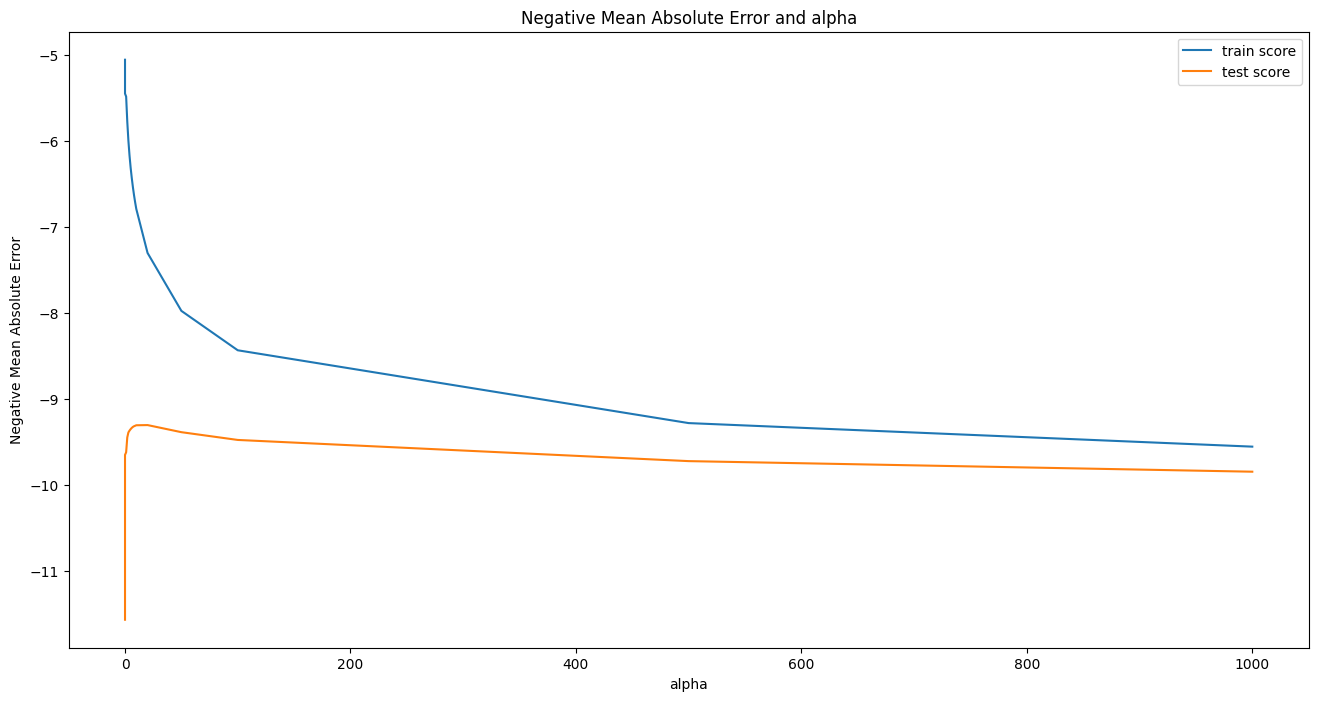

In [12]:
cv_results = pd.DataFrame(grid_search.cv_results_)
# changing datatype of 'param_alpha' into int
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.figure(figsize=(16,8))
plt.plot(cv_results['param_alpha'],cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'],cv_results['mean_test_score'])

plt.title('Negative Mean Absolute Error and alpha')
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.legend(['train score','test score'],loc='upper right')

In [13]:
best_models['Ridge'] = grid_search.best_estimator_
grid_search.best_params_

{'alpha': 20}

In [14]:
# Initialising ElasticNet()
model = ElasticNet() 

grid_search = GridSearchCV(estimator=model,
                       param_grid=params,
                       scoring='neg_mean_absolute_error',
                       cv=5,
                       return_train_score=True,
                       verbose=1)
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

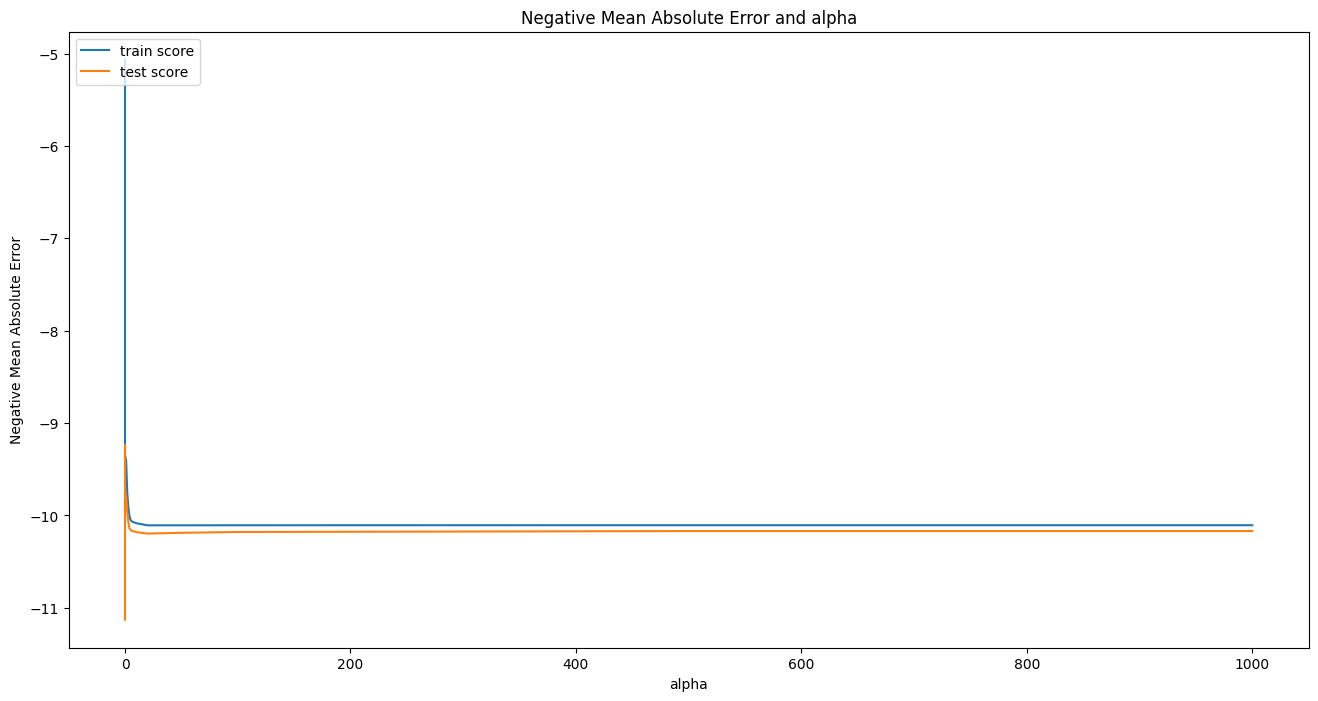

In [15]:
# change param_alpha datatype to float
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.figure(figsize=(16,8))
plt.plot(cv_results['param_alpha'],cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'],cv_results['mean_test_score'])

plt.title('Negative Mean Absolute Error and alpha')
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.legend(['train score','test score'],loc='upper left')

plt.show()

In [16]:
best_models['ElasticNet'] = grid_search.best_estimator_
grid_search.best_params_

{'alpha': 0.05}

In [17]:
model = LinearRegression()
params = {'positive': [True, False]}
grid_search = GridSearchCV(estimator=model,
                           param_grid=params,
                           scoring='neg_mean_absolute_error',
                           cv=5,
                           return_train_score=True,
                           verbose=1)
grid_search.fit(X_train,y_train)


Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'positive': [True, False]}, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

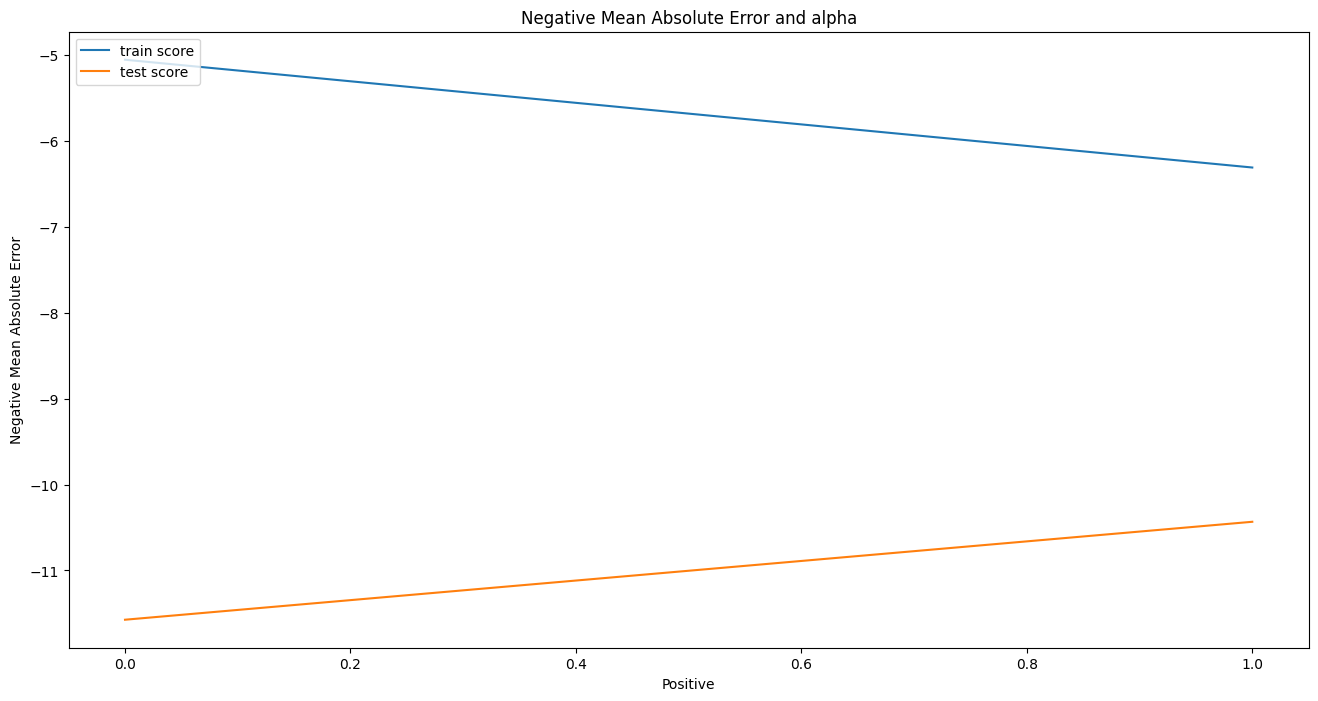

In [18]:
# change param_alpha datatype to float
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results['param_positive'] = cv_results['param_positive'].astype('int32')

# plotting
plt.figure(figsize=(16,8))
plt.plot(cv_results['param_positive'],cv_results['mean_train_score'])
plt.plot(cv_results['param_positive'],cv_results['mean_test_score'])

plt.title('Negative Mean Absolute Error and alpha')
plt.xlabel('Positive')
plt.ylabel('Negative Mean Absolute Error')
plt.legend(['train score','test score'],loc='upper left')

plt.show()

In [19]:
best_models['LinearRegression'] = grid_search.best_estimator_

In [20]:
model = GradientBoostingRegressor()
params = {'n_estimators': [100, 200, 300, 1000, 2000], 'learning_rate': [0.1, 0.5, 1.0]}
grid_search = GridSearchCV(model, params,scoring='neg_mean_absolute_error',
                           cv=5,
                           return_train_score=True,
                           verbose=1)
grid_search.fit(X_train,y_train)

best_models['GradientBoostingRegressor'] = grid_search.best_estimator_


Fitting 5 folds for each of 15 candidates, totalling 75 fits


#### Рассчитаем значение средней абсолютной ошибки для каждой модели.

In [25]:
for model_name in best_models.keys():
    predicted = best_models[model_name].predict(X_test)
    abs_error = mean_absolute_error(predicted, y_test)
    mse_error = mean_squared_error(predicted, y_test)
    print(f'{model_name}: {abs_error}: {mse_error}')


Ridge: 9.40764814557247: 138.76141866370733
ElasticNet: 9.195865059002237: 133.76597581328053
LinearRegression: 8.435394970430766: 120.34203488599367
GradientBoostingRegressor: 9.07414884843212: 133.73598761752402


# Вывод

Как можно заметить, все модели показали одинаково плохой результат.
Основная причина заключается конечно же во входных данных, с помощью которых обучаем модели.

* Вариант решения - это пересмотр структуры входного датасета, то требует дополнительного времени на исследование.
* Возможный вариант решения, это использовать кластеризацию данных. Но для этого необходимо получить данных по гораздо большему количеству разнообразных коробок. Кластеризация так же может негативно отразится на качестве результата.    